In [1]:
%pwd

'/home/larry/tensorflow_prac'

In [2]:
import numpy as np
import tensorflow as tf
import time

import utils

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
# Define paramaters for the model
learning_rate = 0.01
batch_size = 128
n_epochs = 30
n_train = 60000
n_test = 10000

In [5]:
# Step 1: Read in data
mnist_folder = 'data/mnist'
utils.download_mnist(mnist_folder)
train, val, test = utils.read_mnist(mnist_folder, flatten=True)

data/mnist/train-images-idx3-ubyte.gz already exists
data/mnist/train-labels-idx1-ubyte.gz already exists
data/mnist/t10k-images-idx3-ubyte.gz already exists
data/mnist/t10k-labels-idx1-ubyte.gz already exists


In [5]:
type(train)

tuple

In [6]:
len(train)

2

In [7]:
ary1=train[0]

In [8]:
ary1.ndim

2

In [9]:
ary1.shape

(55000, 784)

In [10]:
ary2=train[1]
print(ary2.ndim)
print(ary2.shape)

2
(55000, 10)


In [11]:
ary1[0,1]

0.0

In [14]:
(ary1[0,:]).ndim

1

In [10]:
type(train[0])

numpy.ndarray

2

In [11]:
type(train[1])

numpy.ndarray

In [14]:
train[0].shape

(55000, 784)

In [15]:
train[1].shape

(55000, 10)

### using tf.data.Dataset.from_tensor_slices
### Creates a Dataset whose elements are slices of the given tensors.

In [6]:
train_data = tf.data.Dataset.from_tensor_slices(train)
test_data = tf.data.Dataset.from_tensor_slices(test)

In [7]:
train_data = train_data.batch(batch_size)
test_data = test_data.batch(batch_size)

### using tf.data.Iterator.from_structure
### Creates a new, uninitialized Iterator with the given structure.
### The returned iterator is not bound to a particular dataset, and it has no initializer. To initialize the iterator, run the operation returned by Iterator.make_initializer(dataset).

In [8]:
print(test_data.output_types)
print(test_data.output_shapes)

(tf.float32, tf.float64)
(TensorShape([Dimension(None), Dimension(784)]), TensorShape([Dimension(None), Dimension(10)]))


In [9]:
print(train_data.output_types)
print(train_data.output_shapes)

(tf.float32, tf.float64)
(TensorShape([Dimension(None), Dimension(784)]), TensorShape([Dimension(None), Dimension(10)]))


In [10]:
iterator = tf.data.Iterator.from_structure(train_data.output_types,
                                           train_data.output_shapes)

In [12]:
train_init = iterator.make_initializer(train_data)
test_init = iterator.make_initializer(test_data)

In [13]:
img, label = iterator.get_next()

## test 

In [14]:
with tf.Session() as sess:
    sess.run(train_init)    # drawing samples from train_data
    t1=sess.run([img,label])
    print(t1)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])]


In [15]:
print(type(t1))
print(len(t1))

<class 'list'>
2


In [16]:
print(type(t1[0]))

<class 'numpy.ndarray'>


In [17]:
print(t1[0].shape)

(128, 784)


In [18]:
print(t1[1].shape)

(128, 10)


In [19]:
pic=t1[0][0]
print(type(pic))

<class 'numpy.ndarray'>


In [20]:
print(pic.shape)

(784,)


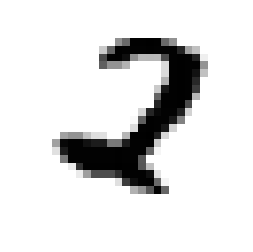

In [22]:
pic=t1[0][10]
pic = pic.reshape(28, 28)
plt.imshow(pic, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

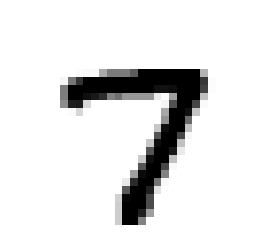

In [23]:
pic=t1[0][11]
pic = pic.reshape(28, 28)
plt.imshow(pic, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

### now back to neural model

In [24]:
w = tf.get_variable(name='weights', shape=(784, 10), initializer=tf.random_normal_initializer(0, 0.01))
b = tf.get_variable(name='bias', shape=(1, 10), initializer=tf.zeros_initializer())

In [25]:
logits = tf.matmul(img, w) + b

In [27]:
# Step 5: define loss function
# use cross entropy of softmax of logits as the loss function
entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label, name='entropy')
loss = tf.reduce_mean(entropy, name='loss') # computes the mean over all the examples in the batch

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [29]:
# Step 7: calculate accuracy with test set
preds = tf.nn.softmax(logits)
correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(label, 1))
accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

In [37]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # train the model n_epochs times
    for i in range(n_epochs):
        sess.run(train_init)    # drawing samples from train_data
        total_loss = 0
        n_batches = 0
        try:
            while True:
                _, l = sess.run([optimizer, loss])
                total_loss += l
                n_batches += 1
        except tf.errors.OutOfRangeError:
            pass
        print(n_batches)
        print('Average loss epoch {0}: {1}'.format(i, total_loss/n_batches))
    wt=sess.run(w)
    bt=sess.run(b)
    print(wt.shape)
    # test the model
    sess.run(test_init)# drawing samples from test_data
    total_correct_preds = 0
    try:
        while True:
            accuracy_batch = sess.run(accuracy)
            total_correct_preds += accuracy_batch
    except tf.errors.OutOfRangeError:
        pass

    print('Accuracy {0}'.format(total_correct_preds/n_test))

430
Average loss epoch 0: 0.36883793927209324
430
Average loss epoch 1: 0.2959113571359668
430
Average loss epoch 2: 0.28565811293069704
430
Average loss epoch 3: 0.2798901690819929
430
Average loss epoch 4: 0.2759807484787564
430
Average loss epoch 5: 0.2730540915284046
430
Average loss epoch 6: 0.27071856535797895
430
Average loss epoch 7: 0.26877541784630266
430
Average loss epoch 8: 0.2671123008048812
430
Average loss epoch 9: 0.2656601290023604
430
Average loss epoch 10: 0.2643735382272754
430
Average loss epoch 11: 0.26322122230086215
430
Average loss epoch 12: 0.2621806071767973
430
Average loss epoch 13: 0.2612347372915856
430
Average loss epoch 14: 0.2603704440039258
430
Average loss epoch 15: 0.2595772160693657
430
Average loss epoch 16: 0.25884656065771744
430
Average loss epoch 17: 0.2581715126023736
430
Average loss epoch 18: 0.25754630068360373
430
Average loss epoch 19: 0.2569660313773987
430
Average loss epoch 20: 0.2564264616647432
430
Average loss epoch 21: 0.25592379

In [50]:
wt.shape

(784, 10)

In [51]:
type(wt)

numpy.ndarray

In [52]:
bt.shape

(1, 10)

In [53]:
bt

array([[-1.5407823 ,  1.7435275 ,  0.47512642, -0.6742775 ,  0.4002248 ,
         2.5497286 , -0.78624064,  1.6106737 , -2.7367003 , -0.54903656]],
      dtype=float32)

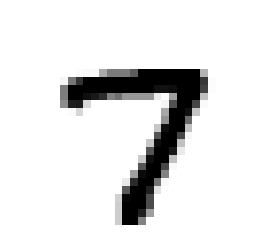

In [34]:
pic=t1[0][11]
pic = pic.reshape(28, 28)
plt.imshow(pic, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [48]:
pic=t1[0][11]
print(pic.shape)

(784,)


In [49]:
type(pic)

numpy.ndarray

###  pic:   1x784
###  wt:    784x10
###  bt:    1x10

### tf.nn.softmax :Computes softmax activations. 

In [66]:
logits_t = np.matmul(pic, wt) + bt
print(logits_t )
smx=tf.nn.softmax(logits_t)
ans=tf.argmax(smx, 1)   # Returns the index with the largest value across axes of a tensor. 
print(type(smx))
print(type(ans))

[[-22.875935  -54.474545  -24.978853  -10.430509  -31.306934   -1.8248308
  -44.162678   16.849167   -6.710227    5.708448 ]]
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


In [64]:
with tf.Session() as sess:
    softmax=sess.run(smx)
    print("step1:softmax result=")
    print(softmax)
    answer=sess.run(ans)
    print(answer)

step1:softmax result=
[[5.5924395e-18 1.0580294e-31 6.8283568e-19 1.4209591e-12 1.2191710e-21
  7.7621038e-09 3.1833636e-27 9.9998546e-01 5.8651417e-11 1.4509122e-05]]
[7]


### Lets test again

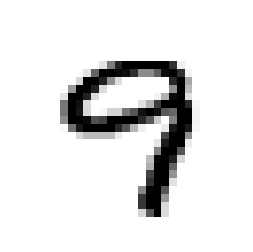

In [74]:
pic=t1[0][17]
pic = pic.reshape(28, 28)
plt.imshow(pic, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [78]:
pic=t1[0][17]
print(pic.shape)
print(wt.shape)

(784,)
(784, 10)


In [79]:
logits_t = np.matmul(pic, wt) + bt
smx=tf.nn.softmax(logits_t)
ans=tf.argmax(smx, 1)  

In [80]:
with tf.Session() as sess:
    softmax=sess.run(smx)
    print("step1:softmax result=")
    print(softmax)
    answer=sess.run(ans)
    print(answer)

step1:softmax result=
[[1.8483324e-14 5.4253347e-21 1.0592445e-13 1.0822100e-05 4.0913928e-06
  5.2674517e-05 2.0588826e-14 8.8073932e-05 7.2861632e-09 9.9984431e-01]]
[9]


##  Lets test again

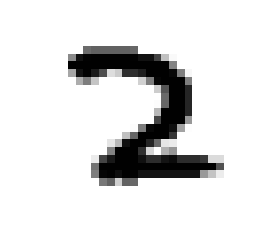

In [83]:
pic=t1[0][27]
pic = pic.reshape(28, 28)
plt.imshow(pic, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [84]:
pic=t1[0][27]
print(pic.shape)
print(wt.shape)

logits_t = np.matmul(pic, wt) + bt
smx=tf.nn.softmax(logits_t)
ans=tf.argmax(smx, 1)  

with tf.Session() as sess:
    softmax=sess.run(smx)
    print("step1:softmax result=")
    print(softmax)
    answer=sess.run(ans)
    print(answer)

(784,)
(784, 10)
step1:softmax result=
[[4.7983544e-11 8.7563675e-13 9.9959129e-01 4.0627204e-04 1.6028833e-13
  4.7938015e-10 1.0353614e-09 1.1759548e-07 2.3372709e-06 1.9839061e-11]]
[2]
